In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from os import listdir

%matplotlib inline
from os.path import join

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat

import rl

matplotlib = rl.plot_utils.set_mpl_defaults(matplotlib)

from os import listdir

from tqdm.notebook import tqdm

/Users/felixmolter/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [3]:
DATA_DIR = join("private", "Carbs2_data_RL")

## Read all data

In [4]:
data_dir = DATA_DIR
conditions_file = "0-session_conditions.xlsx"
physiological_file = "1-physiological_measures.xlsx"

In [5]:
# Read conditions file
conditions_map = {"High_Carb": "highcarb", "High_Pro": "highpro"}
conditions = (
    pd.read_excel(join(data_dir, conditions_file))
    .rename(
        {"Sub_ID": "subject", "Session_1": "session1", "Session_2": "session2"}, axis=1
    )
    .replace(conditions_map)
)

columns = [
    "trial",  # 1-100
    "state",  # type reversal block 1, 2, 3 || FM: I think there's an error and this variable counts the number of reversals
    "trial_state",  # trial count in reversal block 1 to min 10 and max 16
    "correct_response",  # 1 left side correct, 0 right side correct
    "_",  # response recorded: 1 button was pressed, 0 no button was pressed
    "a",  # pressed button 98 leftkey, 99 rightkey || FM: I think there's also 0s in this column, if no response was made?
    "r",  # feedback: 1 smiley, 0 frowny
    "correct",  # response correct: 1 yes, 0 no, 3 if both options were correct (50:50 states)
    "_",  # timestamp "scan0"
    "_",  # timestamp "exp0"
    "_",  # timestamp "stimulus onset"
    "rt",  # response time
    "_",  # timestamp "feedback onset"
    "_",  # timestamp "fixation onset"
    "_",  # intertrial interval
]

# List all mat files
matfiles = [
    file
    for file in listdir(join(data_dir))
    if file.endswith(".mat") and not file.startswith("XPILOT")
]

df = []
for filename in matfiles:
    # Extract subject ID
    # (filenames look like this: "temp_acquisition_RL_05_session02_2_21032017_1217.mat")
    subject = int(filename[20:22])
    session = int(filename[30:32])
    block = int(filename[33:34]) - 1

    condition = conditions.loc[
        conditions["subject"] == subject, f"session{session}"
    ].values[0]

    # Load data of single subject and condition
    x = loadmat(join(data_dir, filename))
    df_sc = pd.DataFrame(x["data_matrix"], columns=columns)
    df_sc["condition"] = condition
    df_sc["subject"] = subject
    df_sc["session"] = session
    df_sc["block"] = block

    # Append to list of all dataframes
    df.append(df_sc)

# Concatenate all dataframes
df = pd.concat(df)

# Reconstruct state variable (coding current reward probabilities, originally bugged in the data)
df["state"] = np.where(
    df["a"] == 0,  # when no button was pressed
    np.nan,  # we can't infer the state
    np.where(
        df["correct"] == 3,  # otherwise, if both options are correct, we're in state 2
        2,
        np.where(
            (
                (df["a"] == 98) & (df["correct"] == 1)
            )  # otherwise, if the participant answered left and that was correct
            | (
                (df["a"] == 99) & (df["correct"] == 0)
            ),  # or the participant answered right and that was incorrect
            0,  # we're in state 1
            1,  # otherwise we're in state 2
        ),
    ),
)

# Reformat variables
df["trial"] = (df["trial"] - 1).astype(np.int32)  # Make trial variable start with 0
df["a"] = (df["a"] - 98).astype(
    np.int32
)  # Recode from 98 = left 99 = right to 0 = left, 1 = right
df.loc[df["a"] == -98, "a"] = np.nan
df["s"] = 0
df["trial_state"] = df["trial_state"].astype(np.int32)


df = (
    df[
        [
            "subject",
            "block",
            "trial",
            "trial_state",
            "state",
            "s",
            "a",
            "r",
            "session",
            "condition",
        ]
    ]
    .sort_values(["condition", "subject", "block", "trial"])
    .reset_index(drop=True)
)

In [6]:
def read_data(data_dir, physiological_file, conditions_file):
    """This function 
     1) reads, processes and combines all .mat files
        containing behavioural data from the prior experiment
        run in Soyoung's Lab and transforms them into a single
        pandas.DataFrame.
     2) reads and processes the physiological data
    
    Args:
        data_dir (str): Path to the data directory with folders for data from each condition.
        physiological_file (str): Filename of the file containing the physiological data. Assumed to be in `data_dir`.
        conditions_file (str): Filename of the file containing the mapping of sessions to conditions. Assumed to be in `data_dir`.
    
    Returns:
        Tuple of pandas.DataFrames: Behavioural data, physiological data
    """

    # Read conditions file
    conditions_map = {"High_Carb": "highcarb", "High_Pro": "highpro"}
    conditions = (
        pd.read_excel(join(data_dir, conditions_file))
        .rename(
            {"Sub_ID": "subject", "Session_1": "session1", "Session_2": "session2"},
            axis=1,
        )
        .replace(conditions_map)
    )

    # Read behavioural data
    columns = [
        "trial",  # 1-100
        "state",  # type reversal block 1, 2, 3 || FM: I think there's an error and this variable counts the number of reversals
        "trial_state",  # trial count in reversal block 1 to min 10 and max 16
        "correct_response",  # 1 left side correct, 0 right side correct
        "_",  # response recorded: 1 button was pressed, 0 no button was pressed
        "a",  # pressed button 98 leftkey, 99 rightkey || FM: I think there's also 0s in this column, if no response was made?
        "r",  # feedback: 1 smiley, 0 frowny
        "correct",  # response correct: 1 yes, 0 no, 3 if both options were correct (50:50 states)
        "_",  # timestamp "scan0"
        "_",  # timestamp "exp0"
        "_",  # timestamp "stimulus onset"
        "rt",  # response time
        "_",  # timestamp "feedback onset"
        "_",  # timestamp "fixation onset"
        "_",  # intertrial interval
    ]

    # List all mat files
    matfiles = [
        file
        for file in listdir(join(data_dir))
        if file.endswith(".mat") and not file.startswith("XPILOT")
    ]

    df = []
    for filename in matfiles:
        # Extract subject ID
        # (filenames look like this: "temp_acquisition_RL_05_session02_2_21032017_1217.mat")
        subject = int(filename[20:22])
        session = int(filename[30:32])
        block = int(filename[33:34]) - 1

        condition = conditions.loc[
            conditions["subject"] == subject, f"session{session}"
        ].values[0]

        # Load data of single subject and condition
        x = loadmat(join(data_dir, filename))
        df_sc = pd.DataFrame(x["data_matrix"], columns=columns)
        df_sc["condition"] = condition
        df_sc["subject"] = subject
        df_sc["session"] = session
        df_sc["block"] = block

        # Append to list of all dataframes
        df.append(df_sc)

    # Concatenate all dataframes
    df = pd.concat(df)

    # Reconstruct state variable (coding current reward probabilities, originally bugged in the data)
    df["state"] = np.where(
        df["a"] == 0,  # when no button was pressed
        np.nan,  # we can't infer the state
        np.where(
            df["correct"]
            == 3,  # otherwise, if both options are correct, we're in state 2
            2,
            np.where(
                (
                    (df["a"] == 98) & (df["correct"] == 1)
                )  # otherwise, if the participant answered left and that was correct
                | (
                    (df["a"] == 99) & (df["correct"] == 0)
                ),  # or the participant answered right and that was incorrect
                0,  # we're in state 1
                1,  # otherwise we're in state 2
            ),
        ),
    )

    # Reformat variables
    df["trial"] = (df["trial"] - 1).astype(np.int32)  # Make trial variable start with 0
    df["a"] = (df["a"] - 98).astype(
        np.int32
    )  # Recode from 98 = left 99 = right to 0 = left, 1 = right
    df.loc[df["a"] == -98, "a"] = np.nan
    df["s"] = 0
    df["trial_state"] = df["trial_state"].astype(np.int32)

    bh = (
        df[
            [
                "subject",
                "block",
                "trial",
                "trial_state",
                "state",
                "s",
                "a",
                "r",
                "session",
                "condition",
            ]
        ]
        .sort_values(["condition", "subject", "block", "trial"])
        .reset_index(drop=True)
    )

    # Physiological data
    ph = pd.read_excel(join(data_dir, physiological_file))

    ph.rename(
        {
            "Sub_ID": "subject",
            "AUC_Tyr_HighCarb": "tyr-highcarb",
            "AUC_Tyr_HighPro": "tyr-highpro",
            "AUC_Trp_HighCarb": "trp-highcarb",
            "AUC_Trp_HighPro": "trp-highpro",
        },
        axis=1,
        inplace=True,
    )
    # Strip subject column from leading 'S'
    #     ph["subject"] = ph["subject"].apply(lambda x: int(x[1:]))

    ph = (
        pd.wide_to_long(
            ph,
            stubnames=["tyr", "trp"],
            i="subject",
            j="condition",
            sep="-",
            suffix="\\w+",
        )
        .sort_values(["subject", "condition"])
        .reset_index()
    )

    return (bh, ph)

In [7]:
bh, ph = read_data(
    DATA_DIR, physiological_file=physiological_file, conditions_file=conditions_file
)
bh.head()

,subject,block,trial,trial_state,state,s,a,r,session,condition
0,1,0,0,1,0.0,0,1.0,0.0,1,highcarb
1,1,0,1,2,0.0,0,0.0,1.0,1,highcarb
2,1,0,2,3,0.0,0,0.0,1.0,1,highcarb
3,1,0,3,4,0.0,0,0.0,0.0,1,highcarb
4,1,0,4,5,0.0,0,0.0,1.0,1,highcarb


In [8]:
ph.head()

,subject,condition,tyr,trp
0,1,highcarb,0.518,0.688
1,1,highpro,0.487,0.529
2,2,highcarb,0.635,0.838
3,2,highpro,0.593,0.658
4,3,highcarb,0.587,0.823


In [9]:
n_subjects = len(bh["subject"].unique())
n_sessions = 2
n_blocks = 2
n_trials = 100
length_target = n_subjects * n_sessions * n_blocks * n_trials
print(f"Behavioural data should have length {length_target}, has length {len(bh)}.")

Behavioural data should have length 12400, has length 12000.


In [10]:
bh["subject"].value_counts().sort_values()[:5]

13    200
23    200
8     400
15    400
7     400
Name: subject, dtype: int64

In [11]:
bh.loc[bh["subject"] == 13, "condition"].unique()

array(['highpro'], dtype=object)

Subject 13 is missing in `HighCarb` condition.

In [12]:
bh.loc[bh["subject"] == 23, "condition"].unique()

array(['highpro'], dtype=object)

Subject 23 is missing in `HighCarb` condition.

In [13]:
# Compute number of missing responses per subject and condition
pd.isnull(bh["a"]).groupby([bh["subject"], bh["condition"]]).sum()

subject  condition
1        highcarb      0.0
         highpro       1.0
2        highcarb      0.0
         highpro      13.0
3        highcarb      0.0
         highpro       0.0
4        highcarb     72.0
         highpro      21.0
5        highcarb      0.0
         highpro       0.0
6        highcarb      0.0
         highpro       0.0
7        highcarb      5.0
         highpro       1.0
8        highcarb      0.0
         highpro       1.0
9        highcarb      1.0
         highpro       0.0
10       highcarb      1.0
         highpro       0.0
11       highcarb      0.0
         highpro       1.0
12       highcarb      0.0
         highpro       0.0
13       highpro       3.0
14       highcarb      2.0
         highpro      11.0
15       highcarb      2.0
         highpro       4.0
16       highcarb      0.0
         highpro       1.0
17       highcarb     12.0
         highpro       5.0
18       highcarb      2.0
         highpro       1.0
19       highcarb      0.0
         

There are some subjects with a considerable number of trials without response (e.g., subject 4 misses 93 trials in total!).

In [14]:
# Was the task too hard for participants?
# What was their mean accuracy at the end of each reversal phase?
# How many trials did the reversal phases have?
# (note that reversals occured if participants achieved 70% accuracy after at least 10 trials, and after 16 trials otherwise)

# summarize data to the level of reversal phases
# first, infer states heuristically that could not be identified due to missing responses
bh["state_inferred"] = bh["state"].fillna(method="ffill").astype(np.int32)
# also mark trials at the end of the block. Here, phases are cut off, independent of any criteria
bh["last_trial"] = bh["trial"] == 99
bh["reversal_idx"] = (bh["state_inferred"] != bh["state_inferred"].shift()).cumsum()
bh["correct"] = np.where(
    ((bh["state_inferred"] == 0) & (bh["a"] == 0))
    | ((bh["state_inferred"] == 1) & (bh["a"] == 1)),
    1,
    0,
)

# for each phase, compute number of trials and final accuracy
# excluding phases that were cut short by the end of the block
phases = (
    bh.groupby(["subject", "reversal_idx"])
    .agg(
        {
            "correct": "mean",
            "state_inferred": np.nanmean,
            "trial_state": len,
            "last_trial": "max",
        }
    )
    .rename({"last_trial": "block_end", "trial_state": "n_trials"}, axis=1)
)

Some reversals look too short (less than 10 trials) or too long (more than 16 trials), which could be a result of how I handled missing responses. However, these numbers are probably still okay to estimate how difficult the task was, in general.

Also, it looks like all responses in the 50:50 conditions were considered incorrect (these reversal phases seem to be 16 trials long). I am not sure if this is right, it's definitely a discrepancy to my previous modeling of the task.

In [15]:
# Compute subject-wise mean accuracy and numbers of trials
phases_subject_summary = (
    phases.loc[~phases["block_end"] & (phases["state_inferred"] != 2)]
    .groupby("subject")
    .agg({"correct": "mean", "n_trials": "mean"})
)
phases_subject_summary.head()

,correct,n_trials
subject,,
1,0.769966,12.647059
2,0.775110,12.650000
3,0.775412,11.285714
4,0.431092,16.533333
5,0.841093,11.894737


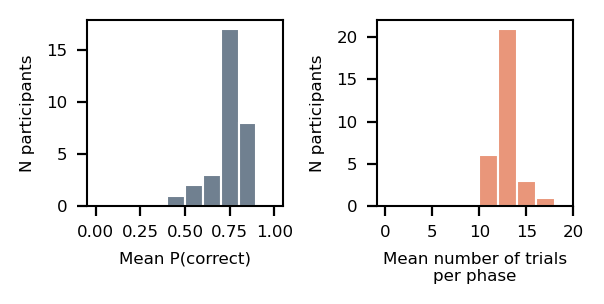

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(3, 1.5), dpi=200)

axs[0].hist(
    phases_subject_summary["correct"], bins=np.linspace(0, 1, 11), edgecolor="white"
)
axs[0].set_xlabel("Mean P(correct)")
axs[0].set_ylabel("N participants")
axs[0].set_xticks(np.arange(0, 1.1, 0.25))


axs[1].hist(
    phases_subject_summary["n_trials"],
    bins=np.arange(0, 20, 2),
    edgecolor="white",
    color="C1",
)
axs[1].set_xlabel("Mean number of trials\nper phase")
axs[1].set_ylabel("N participants")
axs[1].set_xticks(np.arange(0, 21, 5))

fig.tight_layout()

In [17]:
phases_subject_summary.agg(["mean", "sem"], axis=0)

,correct,n_trials
mean,0.746237,12.759698
sem,0.017441,0.193956


These values do not really give an indication that the task was too hard.

# Visualize data

In [18]:
import seaborn as sns
from scipy.stats import sem

In [19]:
ph_desc = ph.groupby("condition")[["tyr", "trp"]].agg([np.mean, sem])
ph_desc

tyr                 trp          
               mean       sem      mean       sem
condition                                        
highcarb   0.606548  0.015406  0.708710  0.016088
highpro    0.628194  0.014639  0.583161  0.015079

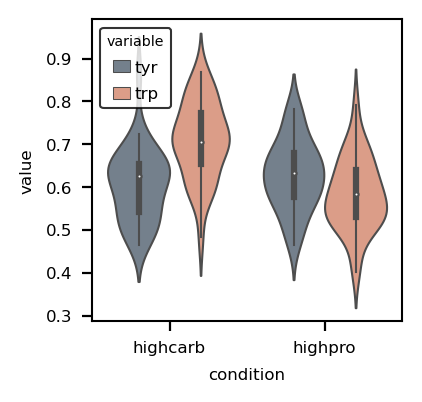

In [20]:
ph_longer = ph.melt(id_vars=["subject", "condition"], value_vars=["tyr", "trp"])
fig, ax = plt.subplots(figsize=(2, 2), dpi=200)
ax = sns.violinplot(
    x="condition", y="value", hue="variable", data=ph_longer, kind="violin", ax=ax
)

Check out differences between conditions

In [21]:
ph_wide = ph.pivot(index="subject", columns="condition")

In [22]:
for var in ["tyr", "trp"]:
    diff = ph_wide[var]["highcarb"] - ph_wide[var]["highpro"]
    ph_wide[(var, "diff")] = diff
ph_wide

tyr              trp            tyr    trp
condition highcarb highpro highcarb highpro   diff   diff
subject                                                  
1            0.518   0.487    0.688   0.529  0.031  0.159
2            0.635   0.593    0.838   0.658  0.042  0.180
3            0.587   0.619    0.823   0.791 -0.032  0.032
4            0.572   0.632    0.603   0.531 -0.060  0.072
5            0.519   0.509    0.696   0.516  0.010  0.180
6            0.466   0.513    0.596   0.519 -0.047  0.077
7            0.611   0.577    0.682   0.608  0.034  0.074
8            0.682   0.668    0.703   0.592  0.014  0.111
9            0.632   0.683    0.822   0.586 -0.051  0.236
10           0.667   0.641    0.613   0.403  0.026  0.210
11           0.542   0.732    0.697   0.669 -0.190  0.028
12           0.493   0.782    0.632   0.707 -0.289 -0.075
13           0.625   0.695    0.768   0.547 -0.070  0.221
14           0.723   0.718    0.586   0.644  0.005 -0.058
15           0.716   0.765    0.717   0.536 -0.049  0.181
16           0.678   0.778    0.869   0.669 -0.100  0.200
17           0.549   0.554    0.677   0.507 -0.005  0.170
18           0.659   0.639    0.719   0.557  0.020  0.162
19           0.474   0.549    0.484   0.432 -0.075  0.052
20           0.579   0.663    0.755   0.611 -0.084  0.144
21           0.508   0.466    0.706   0.522  0.042  0.184
22           0.638   0.675    0.705   0.584 -0.037  0.121
23           0.664   0.684    0.831   0.605 -0.020  0.226
24           0.544   0.605    0.735   0.712 -0.061  0.023
25           0.589   0.578    0.734   0.688  0.011  0.046
26           0.636   0.578    0.790   0.530  0.058  0.260
27           0.503   0.658    0.590   0.634 -0.155 -0.044
28           0.647   0.633    0.714   0.549  0.014  0.165
29           0.865   0.580    0.802   0.553  0.285  0.249
30           0.643   0.589    0.780   0.597  0.054  0.183
31           0.639   0.631    0.615   0.492  0.008  0.123

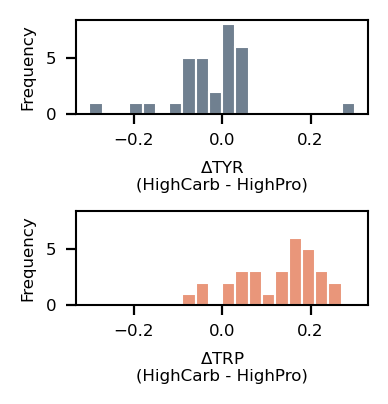

In [23]:
bins = np.linspace(-0.3, 0.3, 21)
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(2, 2), dpi=200)
for i, var in enumerate(["tyr", "trp"]):
    axs[i].hist(ph_wide[(var, "diff")], bins=bins, color=f"C{i}", edgecolor="white")
    axs[i].set_xlabel("$\Delta$" + var.upper() + "\n(HighCarb - HighPro)")
    axs[i].set_ylabel("Frequency")
    axs[i].xaxis.set_tick_params(which="both", labelbottom=True)
fig.tight_layout()

- Tyrosene is a bit higher in `HighPro` condition / lower in `HighCarb` condition
- Tryptophane is higher in `HighCarb` / lower in `HighPro`

# Fit reinforcement learning model

In [24]:
task_vars = rl.task.TaskVars(n_trials=100, n_blocks=2, n_options=2, n_states=1)

In [25]:
# Initialize estimation variables

# Define parameters to estimate
parameters = ["alpha_pos", "alpha_neg", "beta"]

# Set boundaries (used to initialize and constrain estimation)
bounds = {"alpha_pos": (0, 1), "alpha_neg": (0, 1), "beta": (0.01, 100)}

# Note, that we also need to specify the agent_class (i.e., the agent "model")
est_vars = rl.estimation.EstimationVars(
    task_vars,
    agent_class=rl.agent.DualLearningRateAgent,
    parameters=parameters,
    bounds=bounds,
    n_sp=5,
)

# Initialize estimation instance
est = rl.estimation.Estimation(est_vars)

## Fit `HighCarb` and `HighPro` conditions separately

In [26]:
# Initialize agent_vars
agent_vars = rl.agent.AgentVars(variant="r")

results = {}

# Cycle over conditions
conditions = ["highcarb", "highpro"]
for condition in conditions:
    print(f"Estimating parameters for '{condition}' condition.")

    results[condition] = []

    # Cycle over subjects with data in that condition
    for subject in tqdm(bh.loc[bh["condition"] == condition, "subject"].unique()):
        print(f"  Subject {subject}")

        # Subject DataFrame
        df_s = bh.loc[(bh["subject"] == subject) & (bh["condition"] == condition)]

        # Now we can estimate the maximum likelihood parameters
        result = est.estimate(data=df_s, agent_vars=agent_vars, seed=1)

        # Save results to DataFrame
        result_df = pd.DataFrame(
            dict(
                subject=subject,
                nll=result[0],
                bic=result[1],
                alpha_pos=result[2][0],
                alpha_neg=result[2][1],
                beta=result[2][2],
            ),
            index=[subject],
        )
        results[condition].append(result_df)

    # Concatenate results for this condition, across subjects
    results[condition] = (
        pd.concat(results[condition]).sort_values("subject").reset_index(drop=True)
    )
    results[condition]["condition"] = condition

# Concatenate results across conditions
results = pd.concat([results[condition] for condition in conditions]).reset_index(
    drop=True
)
results.to_csv("parklab_RWpn-estimates.csv")

Estimating parameters for 'highcarb' condition.


  Subject 1
  Subject 2
  Subject 3
  Subject 4
  Subject 5
  Subject 6
  Subject 7
  Subject 8
  Subject 9
  Subject 10
  Subject 11
  Subject 12
  Subject 14
  Subject 15
  Subject 16
  Subject 17
  Subject 18
  Subject 19
  Subject 20
  Subject 21
  Subject 22
  Subject 24
  Subject 25
  Subject 26
  Subject 27
  Subject 28
  Subject 29
  Subject 30
  Subject 31

Estimating parameters for 'highpro' condition.


  Subject 1
  Subject 2
  Subject 3
  Subject 4
  Subject 5
  Subject 6
  Subject 7
  Subject 8
  Subject 9
  Subject 10
  Subject 11
  Subject 12
  Subject 13
  Subject 14
  Subject 15
  Subject 16
  Subject 17
  Subject 18
  Subject 19
  Subject 20
  Subject 21
  Subject 22
  Subject 23
  Subject 24
  Subject 25
  Subject 26
  Subject 27
  Subject 28
  Subject 29
  Subject 30
  Subject 31



# Parameter recovery of the estimated parameters with the task used

# Perform analyses on parameter estimates and physiological measures

In [27]:
# join DataFrames
df = (
    results.merge(ph, on=["subject", "condition"], how="outer")
    .sort_values(["subject", "condition"])
    .reset_index(drop=True)[
        [
            "subject",
            "condition",
            "tyr",
            "trp",
            "nll",
            "bic",
            "alpha_pos",
            "alpha_neg",
            "beta",
        ]
    ]
)
df.head()

,subject,condition,tyr,trp,nll,bic,alpha_pos,alpha_neg,beta
0,1,highcarb,0.518,0.688,58.204492,132.303936,0.024620,0.696167,100.000000
1,1,highpro,0.487,0.529,47.103290,110.101532,0.341132,0.712781,12.456673
2,2,highcarb,0.635,0.838,48.861595,113.618143,0.169795,0.957970,100.000000
3,2,highpro,0.593,0.658,87.969162,191.833276,1.000000,0.693462,2.489275
4,3,highcarb,0.587,0.823,55.780248,127.455447,0.419143,0.749337,9.396772


## Correlation of parameters and physiological measures across conditions

In [28]:
from scipy.stats import linregress

In [29]:
def pairplot(df):
    """This function makes a plot of all pairs
    of variables in the dataframe and runs simple
    linear regressions.
    
    Args:
        df (pandas.DataFrame): A dataframe with all variables of interest.
    
    Returns:
        matplotlib.figure, numpy.array of matplotlib.axes
    """
    # Count variables
    vars = df.columns
    nVars = len(vars)

    # Make a figure with some axes
    fig, axs = plt.subplots(
        nVars, nVars, figsize=(nVars, 4 / 5 * nVars), dpi=200, sharex="col",
    )

    # Cycle over all variables across rows
    for i, var_y in enumerate(vars):

        # and columns
        for j, var_x in enumerate(vars):
            ax = axs[i, j]

            # Switch off upper right triangle
            if j > i:
                ax.axis("off")

            # Make a histogram on diagonal
            elif var_x == var_y:
                ax.hist(df[var_x], edgecolor="white")
                ax.set_title(var_x)

            # Otherwise make a regression plot
            else:
                # Scatter plot
                x = df[var_x].values
                y = df[var_y].values
                ax.plot(x, y, "o", markeredgewidth=0.3)

                # Run linear regression
                b, a, r, p, _ = linregress(x=x, y=y)

                if p < 0.05:
                    pstr = "*"
                elif p < 0.01:
                    pstr = "**"
                elif p < 0.001:
                    pstr = "***"
                else:
                    pstr = ", n.s."

                # Print linear regression results
                print(
                    f"{var_y} ~ {var_x}\n  b={b:.2f}, a={a:.2f}, r={r:.2f}, p={p:.2f}{pstr}\n"
                )

                # Plot regression line
                xs = np.linspace(x.min(), x.max(), 100)
                ax.plot(xs, a + b * xs, color="black")

                # Add annotation with linear regression results
                ax.annotate(
                    f"b={b:.2f}, a={a:.2f}\nr={r:.2f}, p={p:.2f}",
                    (0.95, 0.05),
                    ha="right",
                    va="bottom",
                    xycoords="axes fraction",
                    fontsize="xx-small",
                )

            # Add x- and y-labels to the outer axes
            if i == (nVars - 1):
                ax.set_xlabel(var_x)
            if j == 0:
                ax.set_ylabel(var_y)
            if i == j:
                ax.set_ylabel("Frequency")

    fig.tight_layout()

    return fig, axs

trp ~ tyr
  b=0.31, a=0.45, r=0.25, p=0.06, n.s.

alpha_pos ~ tyr
  b=-0.26, a=0.85, r=-0.07, p=0.61, n.s.

alpha_pos ~ trp
  b=-0.84, a=1.22, r=-0.26, p=0.04*

alpha_neg ~ tyr
  b=0.02, a=0.77, r=0.01, p=0.94, n.s.

alpha_neg ~ trp
  b=0.16, a=0.68, r=0.09, p=0.48, n.s.

alpha_neg ~ alpha_pos
  b=0.01, a=0.78, r=0.03, p=0.85, n.s.

beta ~ tyr
  b=-58.47, a=61.58, r=-0.13, p=0.33, n.s.

beta ~ trp
  b=-46.68, a=55.45, r=-0.13, p=0.33, n.s.

beta ~ alpha_pos
  b=-41.11, a=53.79, r=-0.35, p=0.01*

beta ~ alpha_neg
  b=54.35, a=-17.16, r=0.25, p=0.05, n.s.



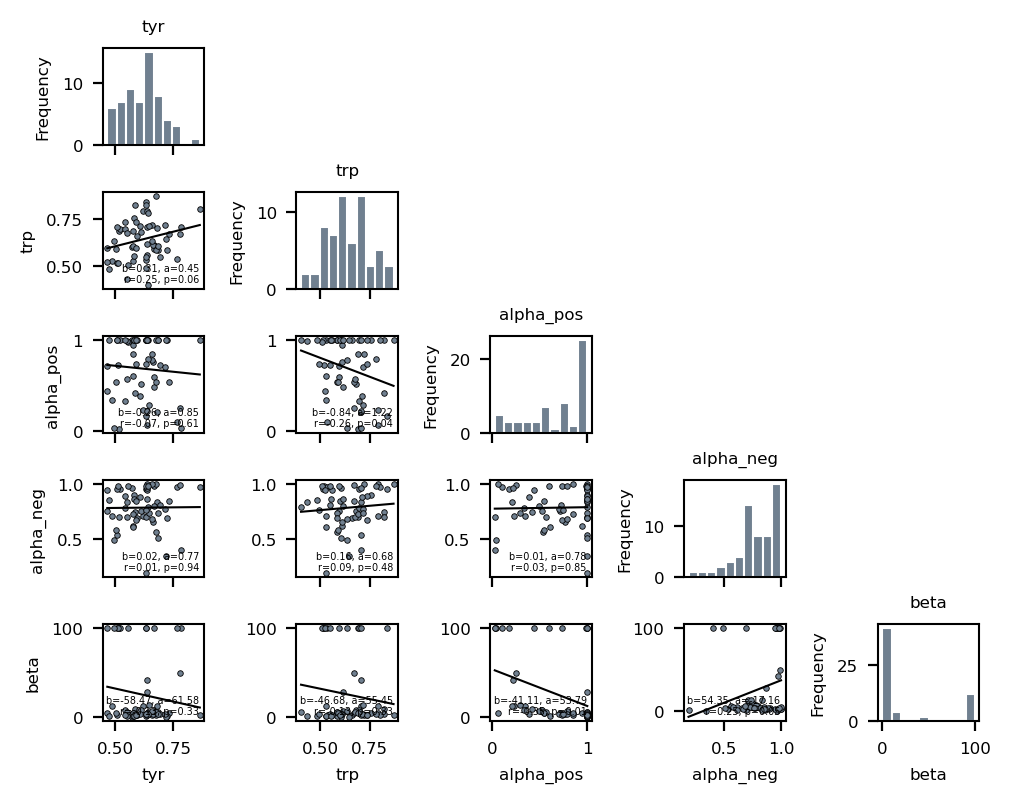

In [30]:
pairplot(df[["tyr", "trp", "alpha_pos", "alpha_neg", "beta"]].dropna());

## Correlation of learning rates and physiological measures, within each condition

'highcarb' condition
trp ~ tyr
  b=0.44, a=0.44, r=0.43, p=0.02*

alpha_pos ~ tyr
  b=0.43, a=0.38, r=0.11, p=0.58, n.s.

alpha_pos ~ trp
  b=-0.33, a=0.88, r=-0.08, p=0.67, n.s.

alpha_neg ~ tyr
  b=0.70, a=0.39, r=0.42, p=0.02*

alpha_neg ~ trp
  b=0.57, a=0.41, r=0.35, p=0.07, n.s.

alpha_neg ~ alpha_pos
  b=0.09, a=0.76, r=0.21, p=0.29, n.s.

beta ~ tyr
  b=-98.67, a=79.81, r=-0.26, p=0.18, n.s.

beta ~ trp
  b=14.77, a=9.84, r=0.04, p=0.84, n.s.

beta ~ alpha_pos
  b=-43.97, a=48.52, r=-0.46, p=0.01*

beta ~ alpha_neg
  b=-16.28, a=33.45, r=-0.07, p=0.71, n.s.



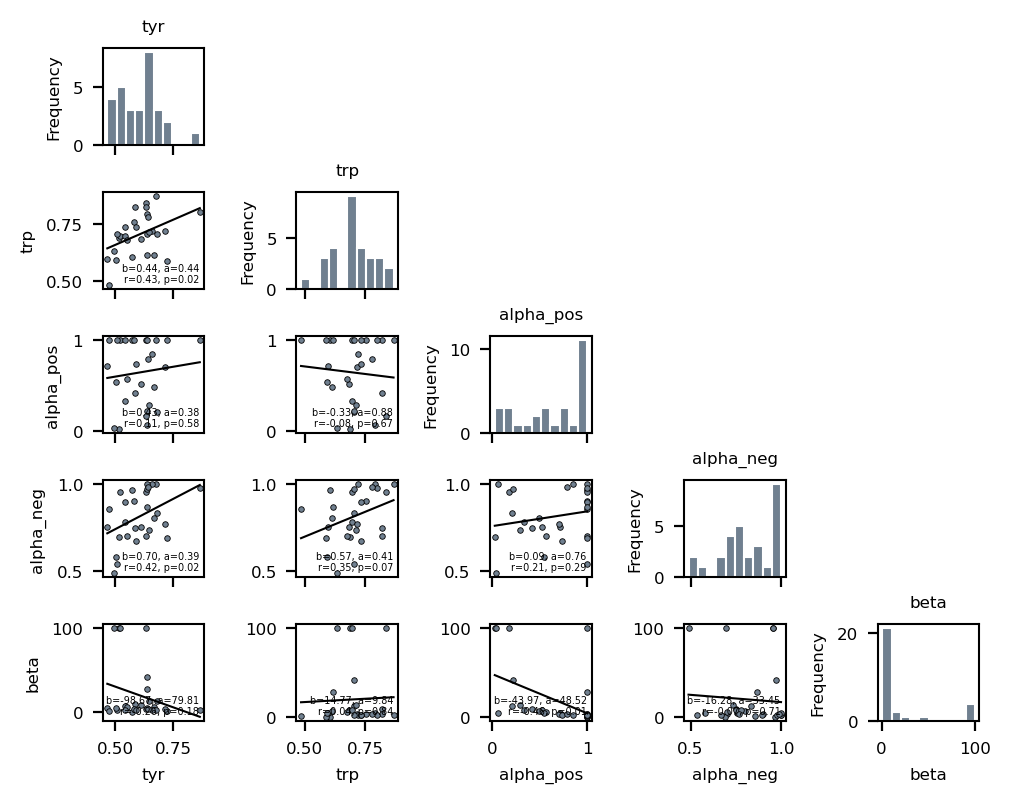

'highpro' condition
trp ~ tyr
  b=0.39, a=0.34, r=0.38, p=0.03*

alpha_pos ~ tyr
  b=-1.19, a=1.47, r=-0.32, p=0.08, n.s.

alpha_pos ~ trp
  b=-1.49, a=1.60, r=-0.41, p=0.02*

alpha_neg ~ tyr
  b=-0.62, a=1.15, r=-0.25, p=0.18, n.s.

alpha_neg ~ trp
  b=-0.56, a=1.09, r=-0.23, p=0.22, n.s.

alpha_neg ~ alpha_pos
  b=-0.05, a=0.80, r=-0.08, p=0.69, n.s.

beta ~ tyr
  b=-36.08, a=53.18, r=-0.07, p=0.71, n.s.

beta ~ trp
  b=-71.02, a=71.92, r=-0.14, p=0.45, n.s.

beta ~ alpha_pos
  b=-43.73, a=62.35, r=-0.32, p=0.08, n.s.

beta ~ alpha_neg
  b=96.35, a=-42.70, r=0.47, p=0.01*



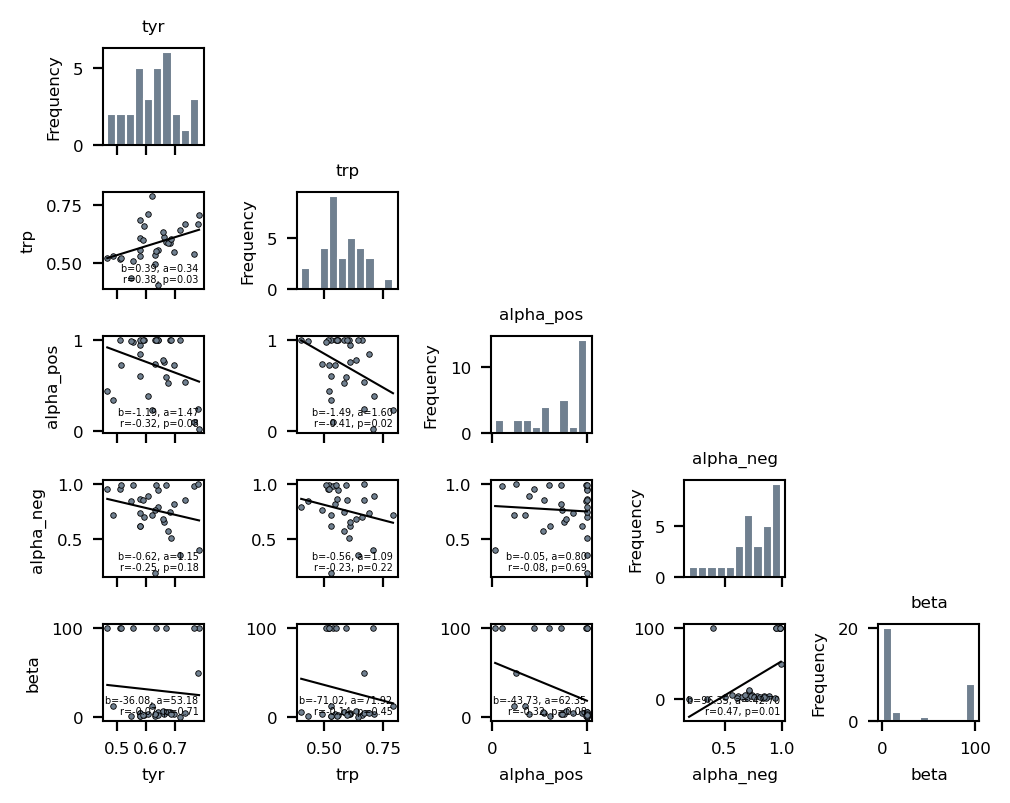

In [31]:
for condition in ["highcarb", "highpro"]:
    print(f"'{condition}' condition")
    df_c = df.loc[df["condition"] == condition]
    pairplot(df_c[["tyr", "trp", "alpha_pos", "alpha_neg", "beta"]].dropna())
    plt.show()

## Correlation of change in physiological measures and change in learning rates

In [32]:
# Make wide dataframe with differences between conditions
df_wide = df.pivot(
    index="subject",
    columns="condition",
    values=["tyr", "trp", "alpha_pos", "alpha_neg"],
).reset_index()

# compute differences
for var in ["tyr", "trp", "alpha_pos", "alpha_neg"]:
    df_wide[(f"d_{var}")] = df_wide[(var, "highcarb")] - df_wide[(var, "highpro")]

df_wide = df_wide[["subject", "d_tyr", "d_trp", "d_alpha_pos", "d_alpha_neg"]]

# Remove multiindex
df_wide.columns = df_wide.columns.droplevel(1)

df_wide.head()

,subject,d_tyr,d_trp,d_alpha_pos,d_alpha_neg
0,1,0.031,0.159,-0.316513,-0.016614
1,2,0.042,0.180,-0.830205,0.264508
2,3,-0.032,0.032,0.188650,0.038944
3,4,-0.060,0.072,0.000000,0.778597
4,5,0.010,0.180,0.000000,0.001436


d_trp ~ d_tyr
  b=0.58, a=0.13, r=0.62, p=0.00*

d_alpha_pos ~ d_tyr
  b=-0.87, a=-0.09, r=-0.22, p=0.26, n.s.

d_alpha_pos ~ d_trp
  b=-0.47, a=-0.02, r=-0.11, p=0.57, n.s.

d_alpha_neg ~ d_tyr
  b=0.10, a=0.05, r=0.04, p=0.84, n.s.

d_alpha_neg ~ d_trp
  b=-0.23, a=0.07, r=-0.09, p=0.66, n.s.

d_alpha_neg ~ d_alpha_pos
  b=-0.10, a=0.04, r=-0.15, p=0.42, n.s.



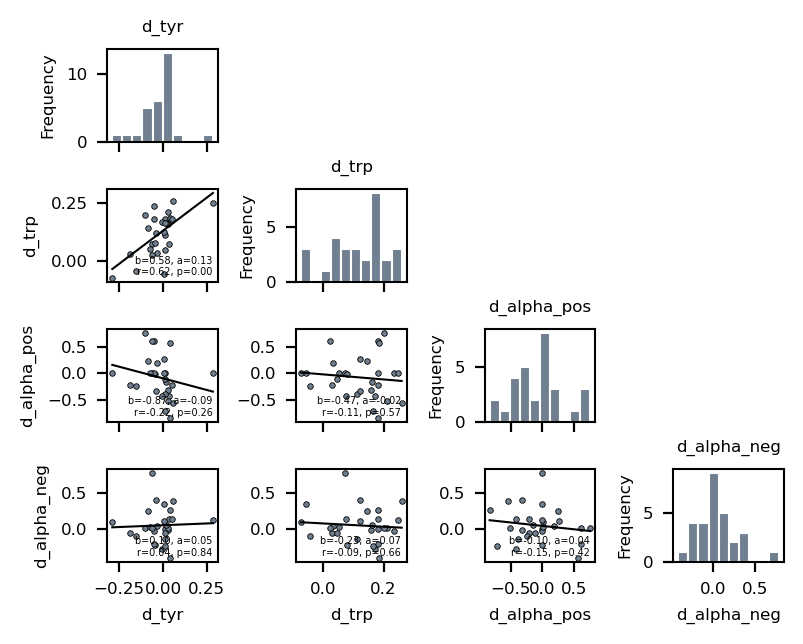

In [33]:
pairplot(df_wide[["d_tyr", "d_trp", "d_alpha_pos", "d_alpha_neg"]].dropna());